In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  2 14:39:15 2017

@author: Charles
"""

import lib_dd.decomposition.ccd_single as ccd_single
import lib_dd.config.cfg_single as cfg_single

#from bisip.utils import get_data
from bisip.models import mcmcinv

import numpy as np
import matplotlib.pyplot as plt

# Revert plot style changes
import matplotlib as mpl
#mpl.rc_file_defaults() # Use local matplotlibrc
mpl.rcdefaults() # Use all default mpl settings

In [2]:
# Import a data file.
# This data is particularely noisy on the amplitude spectra.
# The phase spectra is precise everywhere except it is 
# noisy in a small range between 1 Hz and 60 Hz.
# Measurements and reciprocal electrodes were repeated 5 times each and averaged.
# (in total 10 spectra averaged +/- standard deviation)
filepath = "/Users/Charles/Documents/SIP dat files/AVG_SIP-Reciprocals_K389737.dat"
filename = filepath.split(".")[0].split("/")[-1]

# Using numpy to load data (format is csv, 1 header row)
# Column order: Freq (Hz), Amp (Ohm), Phase (mrad), Amp_err (Ohm), Phase_err (mrad)
# Data file is in decreasing frequency order
datafile = np.loadtxt(filepath, skiprows=1, delimiter=',')

# Format for CCD_tools 
# Need to reverse order arrays with [::-1]
data = np.hstack((datafile[:,1][::-1], datafile[:,2][::-1]))
frequencies = datafile[:,0][::-1]

In [3]:
print(filename, frequencies[0], data[0])

AVG_SIP-Reciprocals_K389737 0.011444 106228.1


In [4]:
# Do the CCD_tools inversion
# set options using this dict-like object
config = cfg_single.cfg_single()
config['frequency_file'] = frequencies
config['data_file'] = data
config['fixed_lambda'] = 10
config['norm'] = 10

# generate a ccd object
ccd_obj = ccd_single.ccd_single(config)

# commence with the actual fitting
ccd_obj.fit_data()

# extract the last iteration
last_it = ccd_obj.results[-1].iterations[-1]

In [5]:
# Make a dictionary with what we learned from CCDtools inversion
priors = {}
priors['R0'] = last_it.stat_pars['rho0'][0]
priors['log_tau'] = np.log10(last_it.Data.obj.tau)
priors['log_m'] = last_it.m[1:] 

# Now priors contain a deterministic solution
# We make the hypothesis that this solution has noise on log_m, log_tau, R0
# The only assumption we make is that this noise is under 10% (choose any value)
# e.g. noise_log_m is drawn from Uniform(lower=-0.1, upper=0.1)
# To estimate this noise we shake the model by adding random noise 
# log_m += noise_log_m

In [18]:
# First we need to define some MCMC parameters
# Load the default parameters
# Change some of them
mcmc_p = mcmcinv.default_mcmc
mcmc_p['nb_iter'] = 10000
mcmc_p['nb_burn'] = 4000
# This should require 2-3 seconds to run

In [19]:
# Commence stochastic deformation of the CCD_tools results
# If mcmc_p is not passed to mcmcinv() then the default dic is used
stoc_ccd_obj = mcmcinv('CCD', filepath, mcmc=mcmc_p,
                       ccdt_priors=priors,
                       )
# Output of mcmcinv is a stochastic inversion result object


Updated CCD priors with new data

MCMC parameters:
 {'adaptive': True, 'nb_chain': 1, 'nb_iter': 10000, 'nb_burn': 4000, 'thin': 1, 'tune_inter': 500, 'prop_scale': 1.0, 'verbose': False, 'cov_inter': 1000, 'cov_delay': 1000}

Chain #1/1
 [-----------------100%-----------------] 10000 of 10000 complete in 2.6 sec

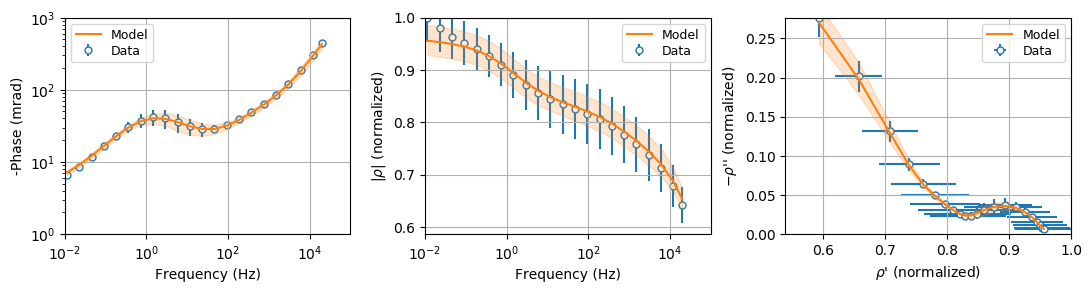

In [20]:
# Plot the average fit (line) with 95% HPD intervals (shaded area)
stoc_ccd_obj.plot_fit()
# The 95% HPD intervals accurately represent the noisy data

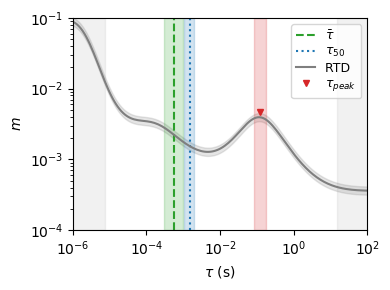

In [21]:
# Plot the resulting RTD and average parameters (lines)
# 95% HPD intervals around the features (shaded areas)
stoc_ccd_obj.plot_rtd()
# Full noise propagation was done onto the RTD features

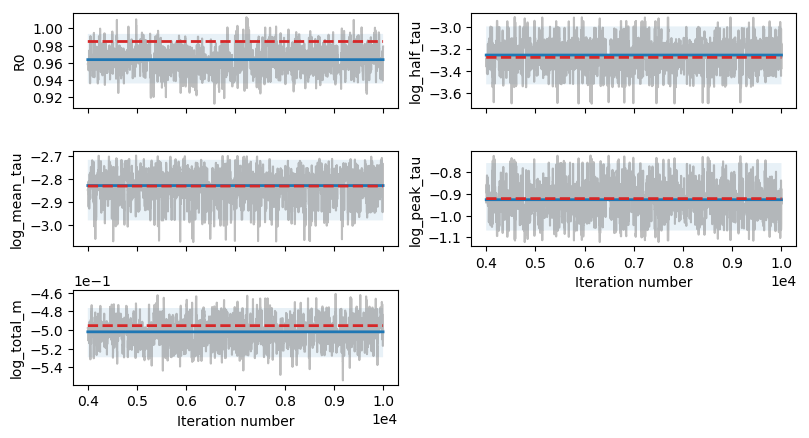

In [22]:
# Plot the traces of the inversion parameters
stoc_ccd_obj.plot_traces()
# The chain is stationary and has very good mixing
# The shaded blue area is the 95% highest probability density interval
# The dashed red line is the result from CCD_tools
# The full blue line is the mean value of the MCMC chain

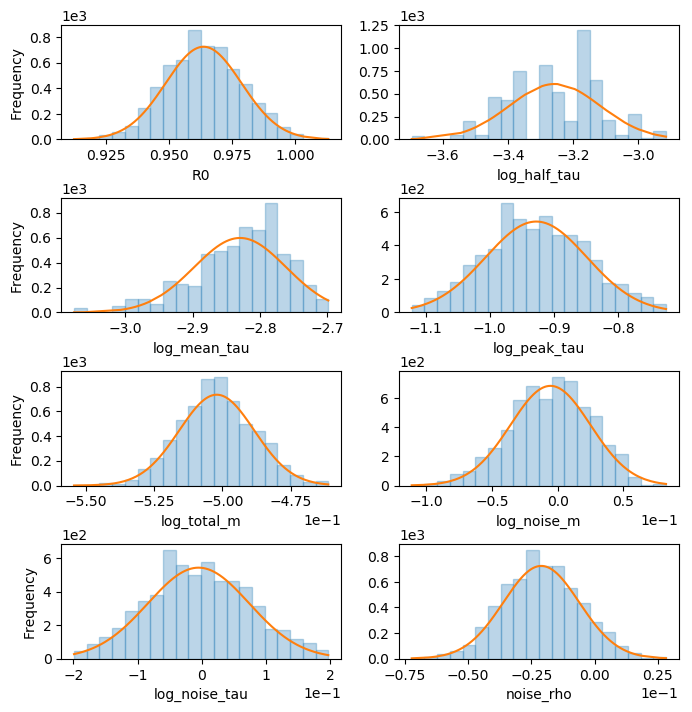

In [23]:
# Plot the histograms of the inversion parameters
stoc_ccd_obj.plot_histograms(save=False)
# The parameters look Gaussian
# We assumed that the noise on the data is random
# Our results show that the noise on the RTD is also random